In [1]:
import os
import numpy as np
import geopandas as gpd
import leafmap
import openeo
from openeo.processes import lte
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
pv_geoms = gpd.read_file("./data/shapefiles/photovoltaic.shp")

threshold_area = 5000 #m^2 ~50mx100m
pv_geoms_32632 = pv_geoms.to_crs(32632)
big_pv_geoms_32632 = pv_geoms_32632.where(pv_geoms_32632["geometry"].area > threshold_area).dropna()
big_pv_geoms = big_pv_geoms_32632.to_crs(4326)
print(f"Number of selected PV Farms: {len(big_pv_geoms_32632)}")

Number of selected PV Farms: 43


Visualize a couple of Solar Farms polygons:

In [3]:
m = leafmap.Map(center=[48.087, 14.51], zoom=17,basemap="Esri.WorldImagery")
m.add_gdf(big_pv_geoms, layer_name="PV")
m

Map(center=[48.087, 14.51], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

This data somes from OSM.

Can we validate it with the one from DescartesLab?

To be sure that the polygons we use are actually covered by PV panels.

Filtering by size, keeping only the polygons covering a large area (how to defined "large"?):

Download the Sentinel-2 data with openEO Platform for each polygon

In [4]:
conn = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


In [5]:

# for i, geom in big_pv_geoms_32632.iterrows():
#     if os.path.exists(f"S2_2022_{i}.nc"):
#         continue
#     print(i)
#     print(geom["geometry"])
#     aoi = np.round(geom["geometry"].buffer(20).bounds,-1)
#     collection = "SENTINEL2_L2A"
#     spatial_extent = {"west": aoi[0],
#                       "east": aoi[2],
#                       "south": aoi[1],
#                       "north": aoi[3],
#                      "crs":"EPSG:32632"}
#     temporal_extent = ["2022-01-01","2022-12-31"]
#     all_bands = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","SCL"]
#     properties={"eo:cloud_cover": lambda x: lte(x, 50)}
    
#     s2_cube = conn.load_collection(
#         collection,
#         temporal_extent = temporal_extent,
#         spatial_extent = spatial_extent,
#         bands = all_bands,
#         properties = properties
#     )
#     try:
#         s2_cube.download(f"./data/netcdfs/S2_2022_{i}.nc")
#     except:
#         continue

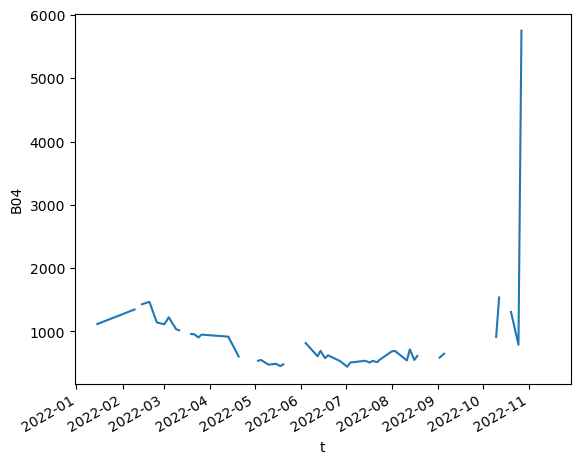

In [6]:
for i, geom in big_pv_geoms_32632.iterrows():
    if i==813: # Showing the plot for an area I'm pretty sure it's covered by PV Panels
        if not os.path.exists(f"./data/netcdfs/S2_2022_{i}.nc"):
            continue
        data = xr.open_dataset(f"./data/netcdfs/S2_2022_{i}.nc",decode_coords="all")
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        clipped = clipped.where(~cloud_mask)
        # aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "W"}).mean() #Resampling to weekly, maybe required to align different time series
        aoi_mean = clipped.mean(dim=["x","y"],skipna=True) # Computing the mean over the area which should be covered by the panels. Other statistics can be computed
        aoi_mean.B04.plot()
        break

Now that we have the time series of Sentinel-2 values for the polygons covering the PV Farms:
- Do we need other polygons covering the non-PV class?
- Can we cluster the current data and check the result? (Don't include the SCL band)
- Can we add a filtering of the polygons based on DescartesLab data/result?